<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [41]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [42]:
#pip install pystan==2.19.1.1

In [43]:
#pip install numpy>=1.15.4

In [44]:
#pip install pandas>=1.0.4

In [45]:
#%load_ext jupyternotify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
import warnings
warnings.simplefilter("ignore")
from prophet import Prophet
plt.rcParams["figure.figsize"] = (18,10)

In [93]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [87]:
data.sort_index(inplace=True) # сделали дату индексом

data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


## Анализ

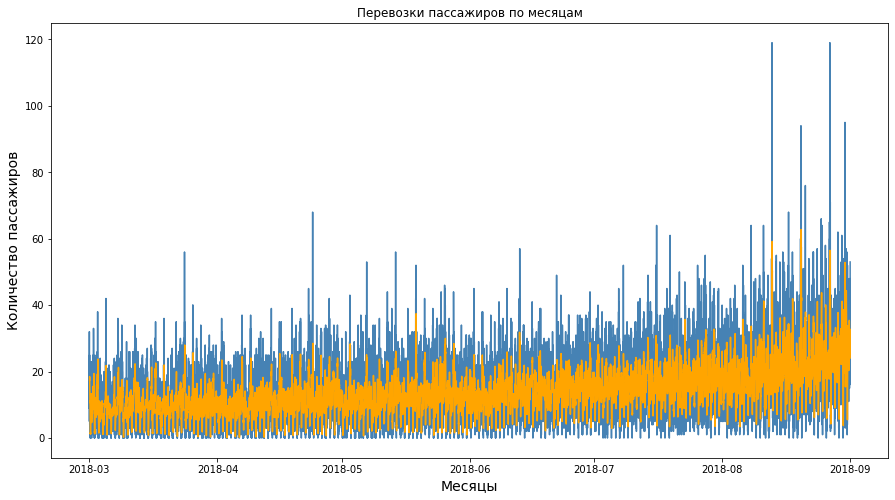

In [88]:
# зададим размер графика
plt.figure(figsize = (15,8))
 
# поочередно зададим кривые (перевозки и скользящее среднее) с подписями и цветом
plt.plot(data, color = 'steelblue')
plt.xlabel('Месяцы', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14)
plt.plot(data.shift().rolling(window = 12, closed='left').mean(), color = 'orange')
plt.title('Перевозки пассажиров по месяцам')
plt.show()

In [95]:
data = data['2018-03-01':'2018-08-31'].resample('1H').sum() # выполнили ресемплирование по 1 часу


    
Выполнили ресэмплирование данных с градацией по часу с применением функции суммирования - отличное и наиболее логичное решение для этой задачи


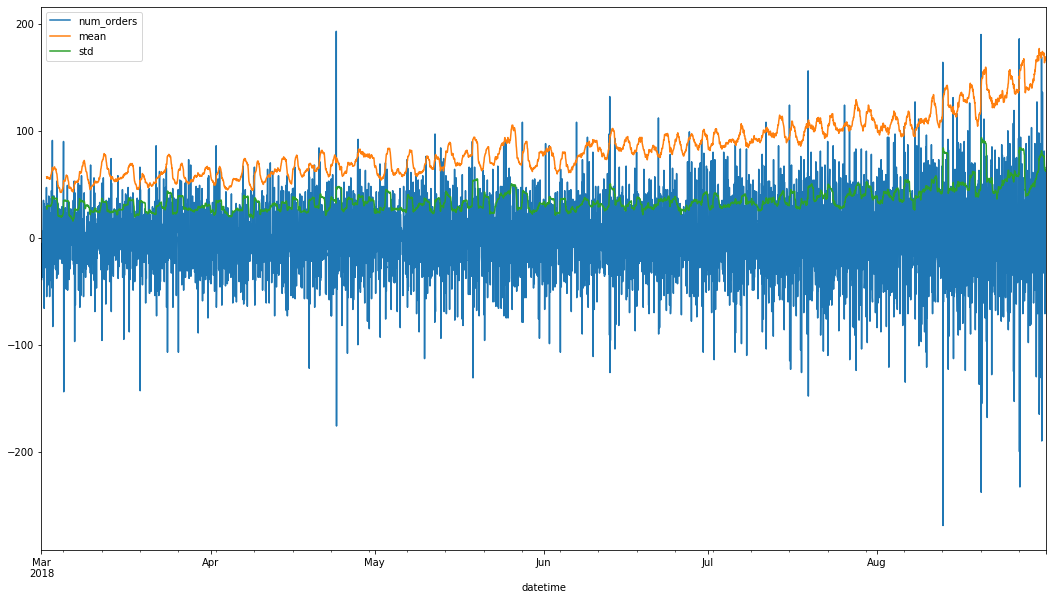

In [96]:
taxi_shift = data - data.shift()
taxi_shift['mean'] = data['num_orders'].rolling(24).mean()
taxi_shift['std'] = data['num_orders'].rolling(24).std()
taxi_shift.plot();


стационарные временные ряды (англ. stationary time series) — это ряды, у которых среднее и стандартное отклонение не меняются. Когда среднее и стандартное отклонение первого ряда меняется медленнее второго, то первый ряд «более стационарный», чем второй.


Данный ряд не станционарен, так-как подвержен росту стандартного отклонения, среднего значения.


Рассмотрим Тренд, Сезонность, Остатки от декомпонизации.</div>

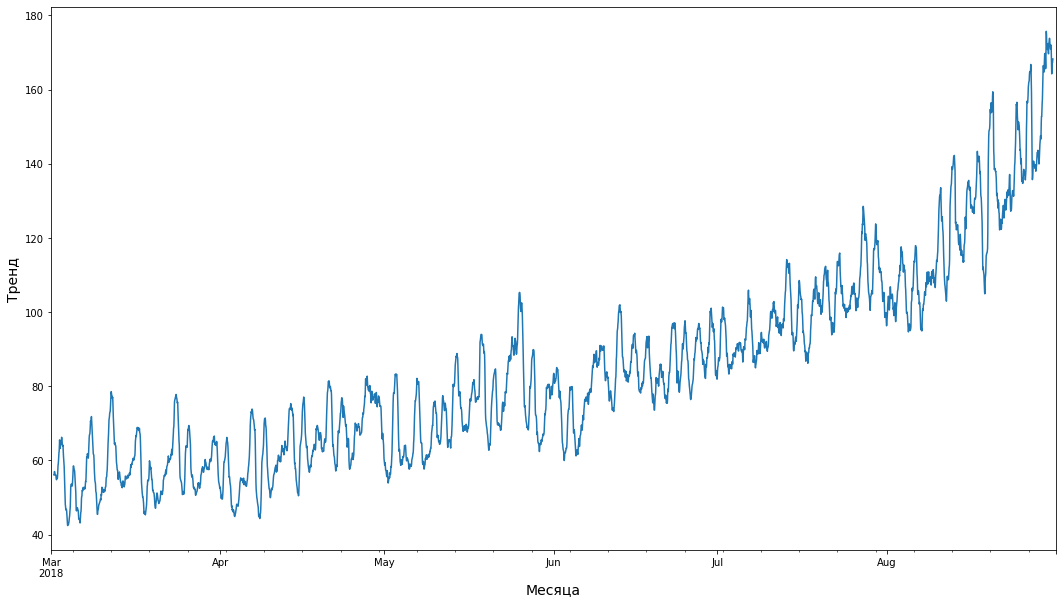

In [52]:
#Тренд
decomposed = seasonal_decompose(data)
decomposed.trend.plot()
plt.xlabel('Месяца', fontsize = 14)
plt.ylabel('Тренд', fontsize = 14);


Заметили, что к концу лета, вероятно к началу сезона дождей - количество заказов выросло, так-же в это время идет активная закупка школьных принадлежностей, что тоже могло стать одним из решающих факторов. Вывод - <b>Все отлично!:</b> Выделен растущий тренд.


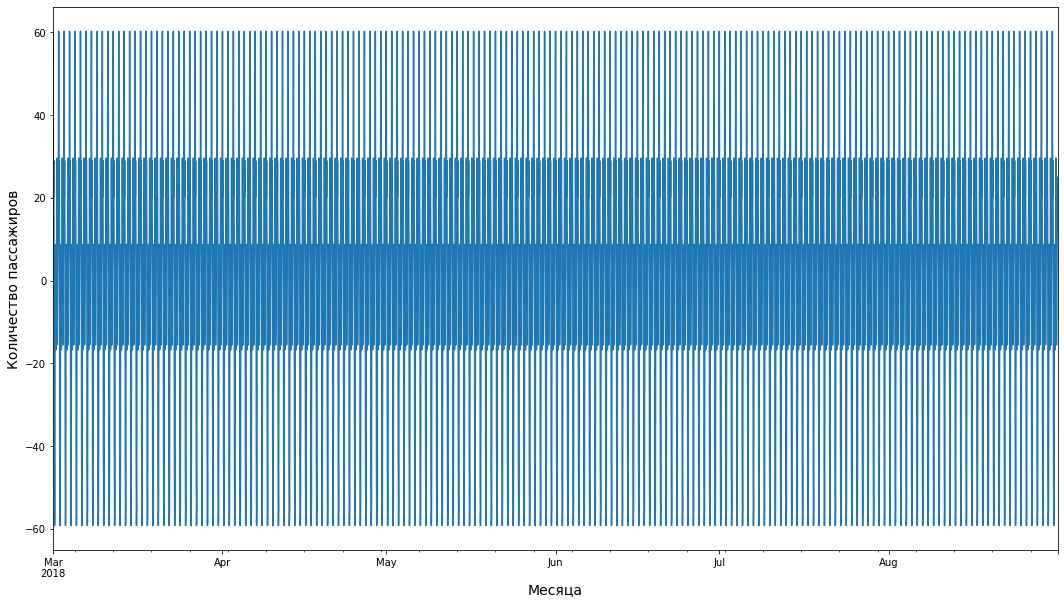

In [53]:
#Сезонность
decomposed.seasonal.plot();
plt.xlabel('Месяца', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14);


Рассмотрим сезонность частями


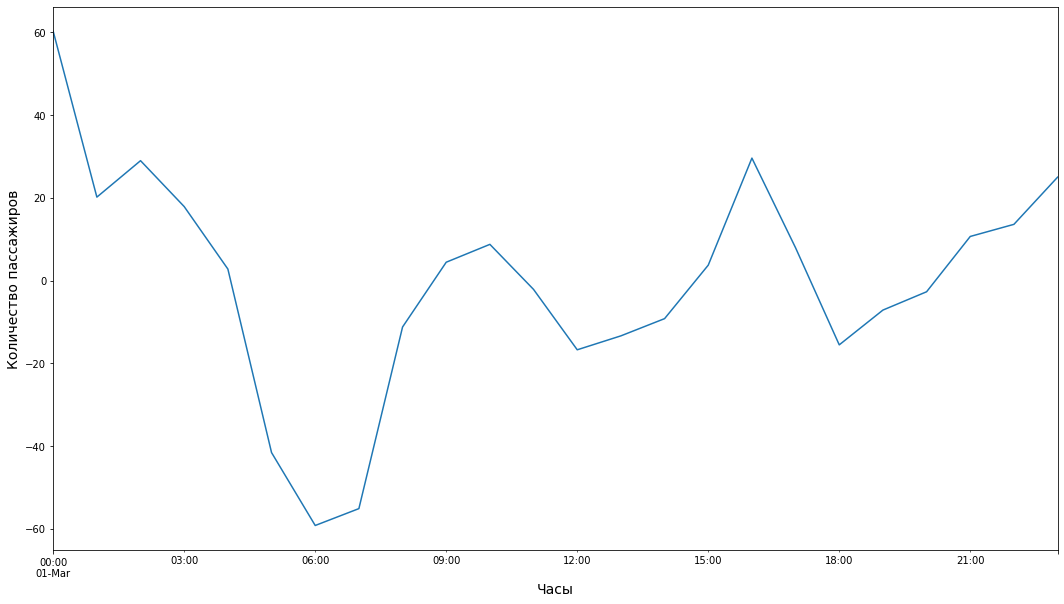

In [54]:
decomposed.seasonal['2018-03-01'].plot()
plt.xlabel('Часы', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14);

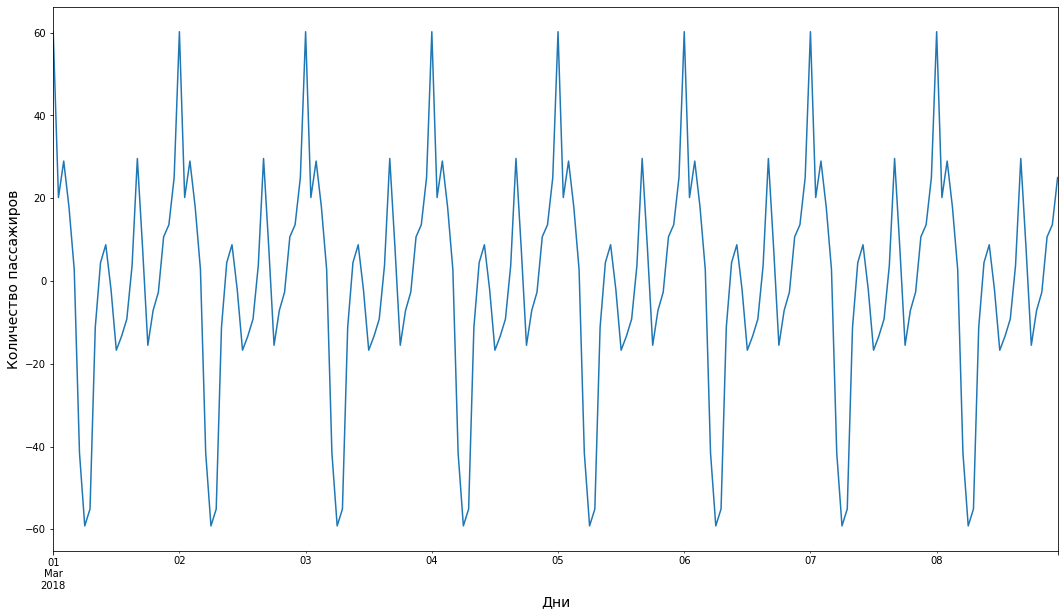

In [55]:
decomposed.seasonal[:'2018-03-08'].plot()
plt.xlabel('Дни', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14);

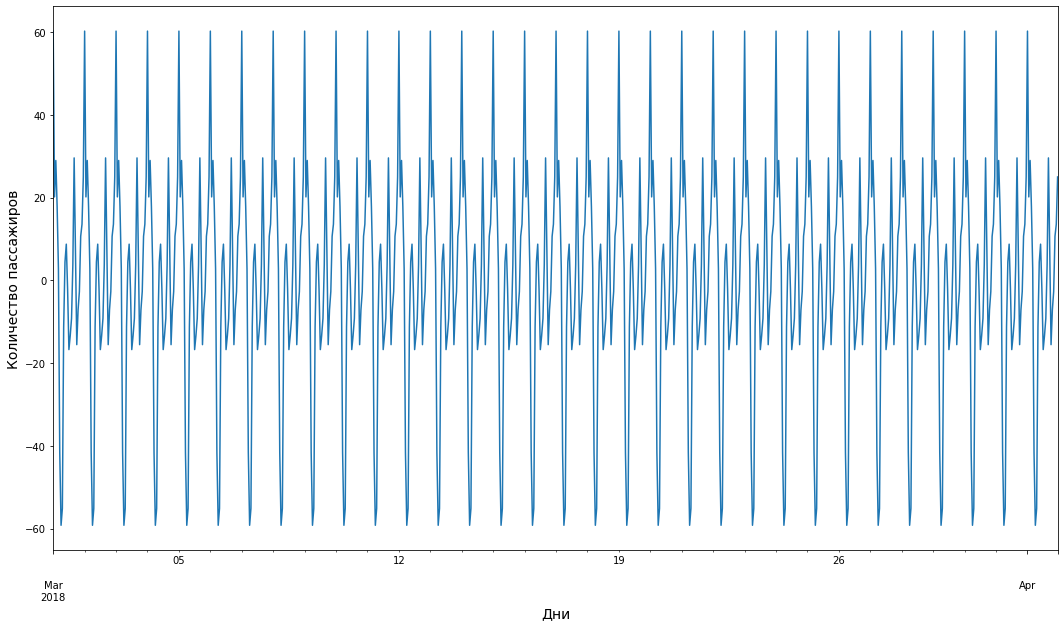

In [56]:
decomposed.seasonal[:'2018-04-01'].plot()
plt.xlabel('Дни', fontsize = 14)
plt.ylabel('Количество пассажиров', fontsize = 14);


Рассмотрев сезонность за день, неделю и месяц, пришел к выводу что: Брать больший промежуток времени - не целесообразно потому, что опять получится непонятный "шум". Что можно сказать: С утра до обеда кол-во заказов имеет свойство расти, ранним утром падать, а вечером снова возрастать, и так по кругу.


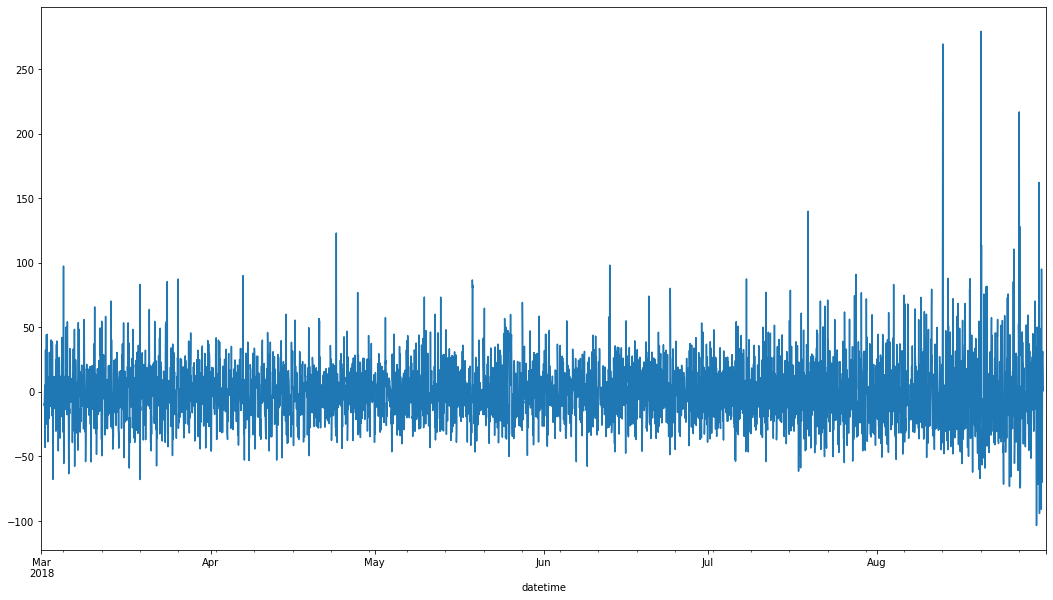

In [57]:
# Остаток декомпонизации
decomposed.resid.plot();


 Тут можно отметить, что к концу периода колебания становятся сильнее - это значит, что в `test` части наших данных будет больше аномальных значений, и модель может делать больше ошибок, прогнозируя эту часть ряда. 

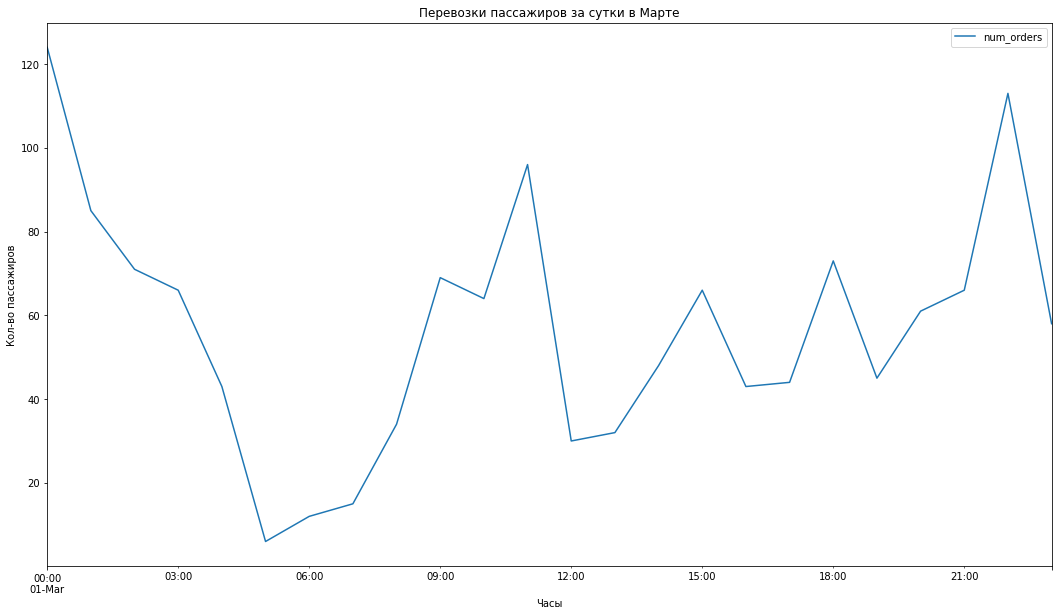

In [58]:
data['2018-03-01':'2018-03-1'].plot()
plt.title('Перевозки пассажиров за сутки в Марте')
plt.xlabel('Часы')
plt.ylabel('Кол-во пассажиров')
plt.show()

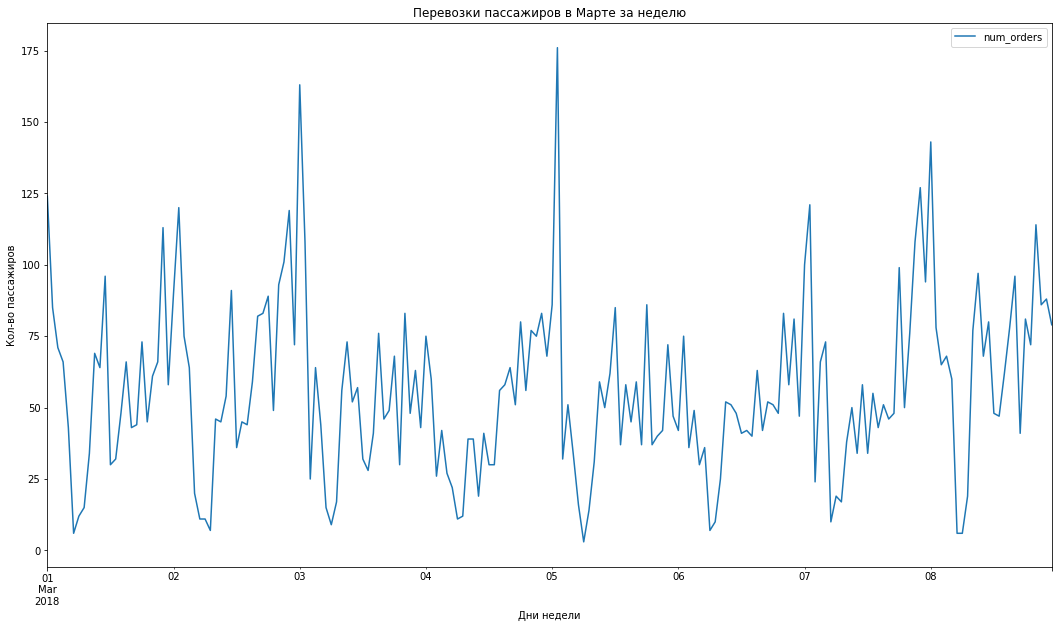

In [59]:
data['2018-03-01':'2018-03-8'].plot()
plt.title('Перевозки пассажиров в Марте за неделю')
plt.xlabel('Дни недели')
plt.ylabel('Кол-во пассажиров')
plt.show()


Вывел выводы по этим графикам в конец раздела


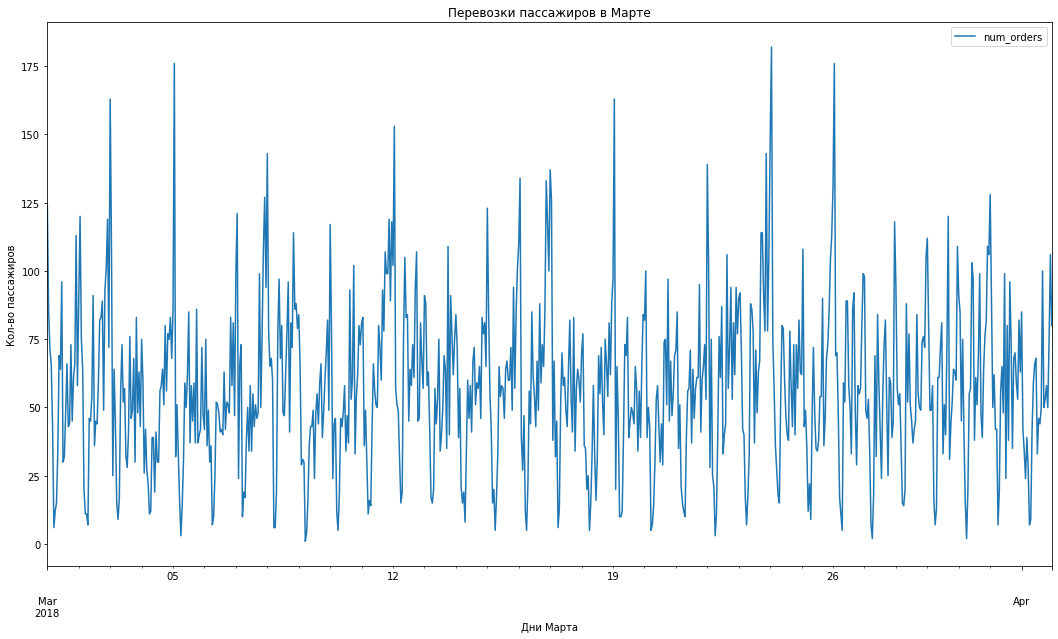

In [60]:
data['2018-03-01':'2018-04-1'].plot()
plt.title('Перевозки пассажиров в Марте')
plt.xlabel('Дни Марта')
plt.ylabel('Кол-во пассажиров')
plt.show()


Исходя из этих графиков можно сделать следующие выводы: <br>
    Количество заказов часто падает ранним утром и возрастает с 8 до 12. Далее вечером 15-18, а потом ближе к позднему вечеру снова возрастает.<br>
    Так-же существует тенденция что, в понедельник, а так-же в выходные количество заказов растет.<br>
    По поводу сезонности - у нас часовая сезонность это утром, вечером количество заказов возрастает, ранним утром падает.
    Дневная - у нас по графикам видно, что в самом начале и ближе к концу растет количество заказов.  <br>
    Недельная - видим, что в понедельник самое большое количество заказов, среди недели самое маленькое. На выходных, например в субботу так-же повышено количество заказов.<br>
    По тренду можем сказать что месячная сезонность у нас тоже рассматривается, ибо летом повышено количество заказов.<br>
    Природа сезонности может быть обусловлена различными факторами, включая:
- Сезонные праздники или события: например, праздники могут привести к увеличению спроса на такси в аэропортах.
- Туристический сезон: в зависимости от местоположения и времени года, туристический сезон может оказывать сильное влияние на заказы такси в аэропортах.
- Рабочие дни и выходные дни: различия в поведении заказов такси могут быть связаны с рабочими днями и выходными днями, когда люди могут совершать больше или меньше путешествий.


<h1><b>Вывод:</h1><b>Мы наблюдаем увеличение дисперсии во временном ряде. Тренд общего количества заказов и пользователей явно растет, что указывает на увеличение активности. Также заметно, что в ранние утренние часы количество заказов резко падает. Временной ряд не является стационарным, поскольку подвержен изменяющемуся во времени тренду.

## Обучение

In [61]:
max_lag = 24 
rolling_mean_size = 48
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()
    data_taxi_copy = data.copy()

In [62]:
make_features(data,'num_orders', max_lag, rolling_mean_size)

train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=42)
train = train.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']



<b>Все отлично!:</b>
Сплитование выполнено корректно как с точки зрения учёта специфики временного ряда (отключено перемешивание), так и размера тестовой выборки. Также выделили признаки для обучения и целевой признак - хорошо!


In [65]:
# GridSearch для RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15]
}
rf_model = RandomForestRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')

In [66]:
grid_search.fit(features_train, target_train)
best_rf_model = grid_search.best_estimator_
print('Лучший параметр', best_rf_model)

# RandomForestRegressor
rf_predictions = best_rf_model.predict(features_train)
rf_rmse = np.sqrt(-grid_search.best_score_)
print('Лучший RMSE на кросс-валидации:', rf_rmse)

Лучший параметр RandomForestRegressor(max_depth=15, n_estimators=150, random_state=42)
Лучший RMSE на кросс-валидации: 26.164459174681895




<b>Все отлично,</b> Для `RandomForestRegressor` оптимизировали гиперпараметры.


Выбрал LGBM потому что все-же у него лучше метрика на сотые-тысячные доли)


In [71]:
# CatBoost
catboost = CatBoostRegressor(random_state=42)
catboost_params = {'depth': [4, 6, 8],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'iterations': [100, 200, 300],
                   }
catboost_grid = GridSearchCV(catboost, catboost_params, scoring='neg_mean_squared_error', cv=tscv)

In [72]:
catboost_grid.fit(features_train, target_train)

0:	learn: 29.4428146	total: 48.2ms	remaining: 4.78s
1:	learn: 29.3068516	total: 49.9ms	remaining: 2.44s
2:	learn: 29.1753417	total: 51.3ms	remaining: 1.66s
3:	learn: 29.0435832	total: 52.5ms	remaining: 1.26s
4:	learn: 28.9280377	total: 53.9ms	remaining: 1.02s
5:	learn: 28.8162554	total: 55ms	remaining: 861ms
6:	learn: 28.7174364	total: 56.4ms	remaining: 749ms
7:	learn: 28.6010175	total: 57.7ms	remaining: 664ms
8:	learn: 28.4837870	total: 59.1ms	remaining: 597ms
9:	learn: 28.3834762	total: 60.5ms	remaining: 544ms
10:	learn: 28.2659484	total: 61.8ms	remaining: 500ms
11:	learn: 28.1551172	total: 63.3ms	remaining: 464ms
12:	learn: 28.0464144	total: 64.7ms	remaining: 433ms
13:	learn: 27.9540008	total: 66.1ms	remaining: 406ms
14:	learn: 27.8316016	total: 67.4ms	remaining: 382ms
15:	learn: 27.7326809	total: 68.7ms	remaining: 361ms
16:	learn: 27.6187255	total: 70ms	remaining: 342ms
17:	learn: 27.5138171	total: 71.3ms	remaining: 325ms
18:	learn: 27.4053232	total: 72.6ms	remaining: 310ms
19:	lea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fca9ef60490>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [73]:
best_catboost_model_params = catboost_grid.best_params_
catboost_rmse = np.sqrt(-catboost_grid.best_score_)

In [83]:
print('Лучшие параметры:', best_catboost_model_params)
print("CatBoost RMSE:", catboost_rmse)

Лучшие параметры: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
CatBoost RMSE: 25.25103586116219


 Для `CatBoostRegressor` оптимизировали гиперпараметры.

In [75]:
#%%notify
# LightGBM
lgbm = LGBMRegressor(random_state=42)
lgbm_params = {'max_depth': [4, 6, 8],
               'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [100, 200, 300],
               'n_jobs':[-1],
               'random_state':[42]}
lgbm_grid = GridSearchCV(lgbm, lgbm_params, scoring='neg_mean_squared_error', cv=tscv)

In [76]:
lgbm_grid.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 6, 8],
                         'n_estimators': [100, 200, 300], 'n_jobs': [-1],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [77]:
best_lgbm_model = lgbm_grid.best_params_
print(best_lgbm_model)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}


In [82]:
lgbm_rmse = np.sqrt(-lgbm_grid.best_score_)
print("LightGBM RMSE:", lgbm_rmse)

LightGBM RMSE: 25.883092206336404


Для `LGBMRegressor` оптимизировали гиперпараметры.

<b>Были задейстевованы следующие модели:<br>
RandomForest который показал не самое лучшее качество 26<br>
    Catboost имеет значение RMSE 25.25
    LGBM имеет RMSE равное25.88
    <br>
    По итогам обучения на тренировчной выборке и после подбора гиперпараметров принято решение использовать LGBM для тестирования. 

## Тестирование

In [79]:
# Предсказание на тестовой выборке
lgbm_pred = lgbm_best_model.predict(features_test)
# Оценка моделей
lgbm_rmse_final = mean_squared_error(target_test, lgbm_pred, squared=False)

print('RMSE LGBM:', lgbm_rmse_final)

RMSE LGBM: 42.20133868857936


In [85]:
# создаём модель DummyRegressor,
# которая предсказывает все значение
# как среднее из массива features
dummy_regr = DummyRegressor(strategy="mean")
# обучаем модель
dummy_regr.fit(features_train, target_train)
# предсказываем значения
pred_dumm = dummy_regr.predict(features_train)
#Оценка (исправлено)
#Dummy_regr_rmse = mean_squared_error(target_train, pred_dumm, squared=False)
#print('RMSE Dummy', dummy_regr_rmse)
#Тестовая выборка
pred_dumm_test = dummy_regr.predict(features_test)
dummy_regr_rmse_test = mean_squared_error(target_test, pred_dumm_test, squared=False)
print('RMSE на тестовой выборке:', dummy_regr_rmse_test)

RMSE на тестовой выборке: 84.5807770460722


<b><h1>Вывод по тестированию:</h1><b>После тестирования получили значение метрики RMSE модели LGBM равной 42.201, это меньше 48 которое задано в ТЗ. <br>
Так-же модель прошла проверку на адекватность,ведь значение RMSE LGBM меньше, чем RMSE Dummy Regressor(на тестовой выборке), а это значит что ее можно использовать.

<b><h1> Вывод по проекту:</h1>
    В ходе проекта мы исследовали исторические данные о заказах такси в аэропортах с целью прогнозирования количества заказов на следующий час. Мы обнаружили увеличение дисперсии во временном ряде и растущий тренд, указывающий на увеличение активности. Также было замечено, что количество заказов снижается в ранние утренние часы. <br>

Мы использовали несколько моделей для прогнозирования, включая RandomForest, Catboost и LGBM. После обучения и подбора гиперпараметров, мы выбрали модель LGBM для тестирования. <br>

Результаты тестирования показали значение метрики RMSE модели LGBM равное 42.201, что меньше заданного порога в ТЗ (48). Модель также прошла проверку на адекватность, поскольку значение RMSE LGBM меньше, чем значение RMSE Dummy Regressor на тестовой выборке. <br>

В целом, проект был выполнен в соответствии с инструкцией. Мы провели анализ данных, обучили разные модели с различными гиперпараметрами и сделали выводы. В проекте был поддержан аккуратный код и структура проекта.